## Table of Contents:

[1. Introduction](#1.-Introduction)

[2. Data Preprocessing](#2.-Data-Preprocessing)

[3. Exploratory Analysis](#3.-Exploratory-Analysis)

[4. RFM Modeling](#4.-RFM-Modeling)
    
[5. Conclusion](#5.-Conclusion)

## **Introduction**

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps to identify customers who are more likely to respond to promotions by segmenting them into various categories.

## **Data Preprocessing**

In [1]:
%%capture
!pip install missingno

In [2]:
# Data Manipulation libraries
import pandas as pd
import numpy as np
import missingno as msno

from datetime import timedelta

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Loading the data
data = pd.read_excel("/content/Online Retail.xlsx", parse_dates=['InvoiceDate'])

Checking the data structure


In [4]:
data.shape

(541909, 8)

In [5]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
# Defining a function to downcast data types for memory efficiency

def downcast_dtypes(df):
    # Identifying columns of different data types
    float_cols = df.select_dtypes(include='float64').columns
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns
    object_cols = df.select_dtypes(include='object').columns

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    df[object_cols] = df[object_cols].astype('category')

    return df

In [8]:
# Initializing the function

data = downcast_dtypes(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  category      
 1   StockCode    541909 non-null  category      
 2   Description  540455 non-null  category      
 3   Quantity     541909 non-null  int16         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float32       
 6   CustomerID   406829 non-null  float32       
 7   Country      541909 non-null  category      
dtypes: category(4), datetime64[ns](1), float32(2), int16(1)
memory usage: 14.4 MB


In [9]:
# Checking for missing values

missing_info = pd.DataFrame({
    'count': data.isnull().sum(),
    'proportion': data.isnull().mean()
})

print(missing_info)

              count  proportion
InvoiceNo         0    0.000000
StockCode         0    0.000000
Description    1454    0.002683
Quantity          0    0.000000
InvoiceDate       0    0.000000
UnitPrice         0    0.000000
CustomerID   135080    0.249267
Country           0    0.000000


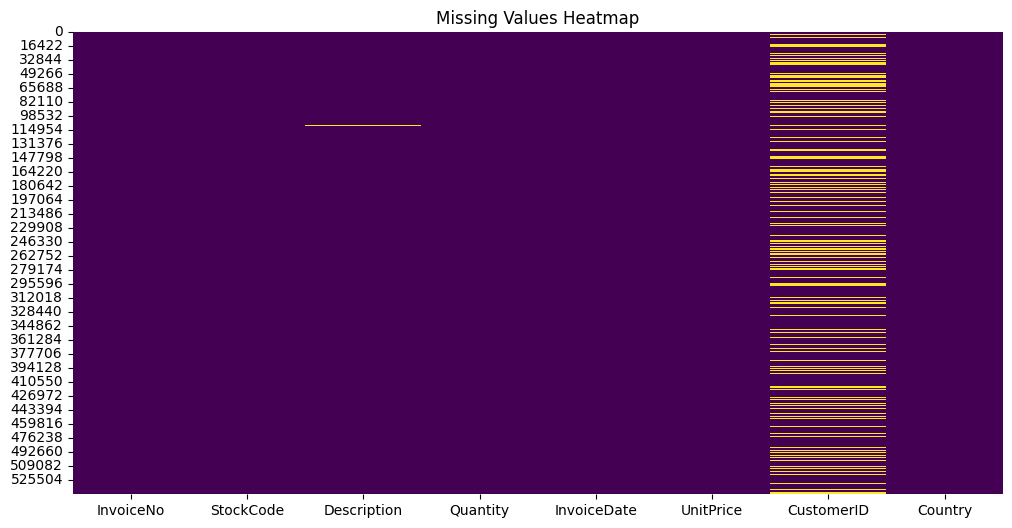

In [10]:
# Visualizing the missing values

plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

**Observation:** It appears that there are some missing values in the Description and CustomerID columns of our dataset.


In [11]:
# Removing null CustomerIDs

main = data.copy()
data = data[pd.notnull(data['CustomerID'])]

In [12]:
# Descriptive Statistics
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.692383
std,63.765079,69.315163,1713.600342
min,-15459.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,15459.000000,38970.000000,18287.000000


**Observation**: It can be observed that the Quantity column has negative values, implying that some products was either returned or refunded.

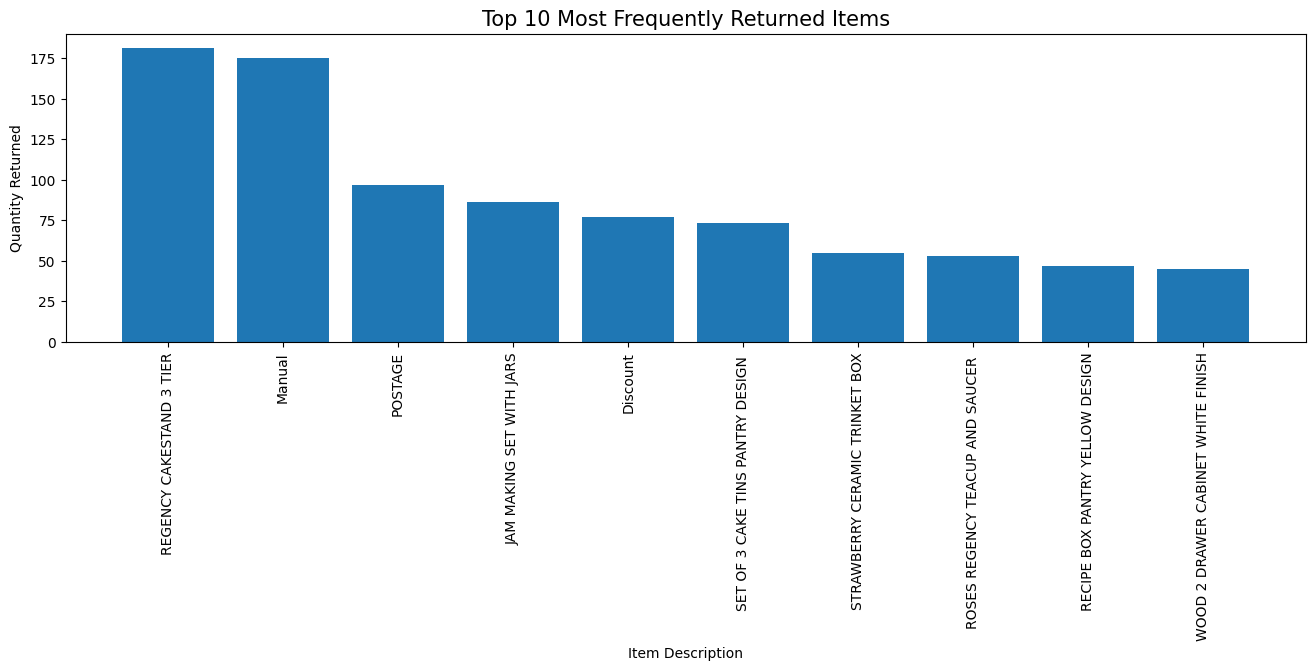

In [13]:
# Filtering for most frequently returned items
refunds = data[data['Quantity'] < 0]
top_refunds = refunds.groupby('Description')['Quantity'].count().nlargest(10).reset_index()

# Plotting the bar chart
plt.figure(figsize=(16, 4))
plt.bar(top_refunds['Description'], top_refunds['Quantity'])
plt.title("Top 10 Most Frequently Returned Items", size=15)
plt.xticks(rotation=90)
plt.xlabel("Item Description")
plt.ylabel("Quantity Returned")
plt.show()


**Observation**: These are some of the most frequently returned items on the site.

Based on the statistics, the highest quantity bought is 15.4K. However, it's important to note that 75% of the Quantity values are less than 15. The large values in Quantity are possible due to the fact that the e-commerce platform is intended for wholesalers. Therefore, the business context helps explain the high values.

Furthermore, the maximum value of UnitPrice is 38.9K, but 75% of prices are below 5. It's worth exploring the reason for these high values.

In [14]:
# Filtering for transactions with prices greater than 1000

data[data['UnitPrice']>1000].tail(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45622,C540271,M,Manual,-1,2011-01-06 11:51:00,1126.000000,12503.0,Spain
73446,C542348,M,Manual,-1,2011-01-27 12:09:00,1715.849976,12539.0,Spain
117052,C546325,M,Manual,-1,2011-03-11 10:15:00,1687.170044,14911.0,EIRE
117053,C546327,M,Manual,-1,2011-03-11 10:18:00,1687.170044,14911.0,EIRE
117054,546328,M,Manual,1,2011-03-11 10:19:00,1687.170044,14911.0,EIRE
117055,546329,M,Manual,1,2011-03-11 10:22:00,1687.170044,14911.0,EIRE
144826,548813,M,Manual,1,2011-04-04 13:03:00,2382.919922,12744.0,Singapore
144828,548813,M,Manual,1,2011-04-04 13:03:00,1252.949951,12744.0,Singapore
144829,548820,M,Manual,1,2011-04-04 13:04:00,2053.070068,12744.0,Singapore
144831,C548830,M,Manual,-1,2011-04-04 13:08:00,2382.919922,12744.0,Singapore


**Observation:** There are some odd categories such as Manual, POSTAGE, DOTCOM POSTAGE, CRUK Commission, and Discount. Since only Discount directly affects sales, we can remove the others from the data.

In [15]:
# Removing the unwanted transactions
data = data[~data['Description'].isin(['POSTAGE', 'DOTCOM POSTAGE', 'CRUK Commission', 'Manual'])]

Lets calculate the total sales value for each transaction from the quantity and unit price.

In [16]:
# Creating a Total Sales feature for the column

data['TotalSales'] = data['Quantity'] * data['UnitPrice']
data.head()

<ipython-input-16-637865eae86e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalSales'] = data['Quantity'] * data['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.299999
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.340000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.340000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.340000


Generating a profile of the dataset

In [17]:

# Calculating the maximum and minimum dates in the dataset
maxdate = data['InvoiceDate'].dt.date.max()
mindate = data['InvoiceDate'].dt.date.min()

# Calculating the unique number of customers and stocks
unique_cust = data['CustomerID'].nunique()
unique_stocks = data['StockCode'].nunique()

# Summing up the total quantity and sales
tot_quantity = data['Quantity'].sum()
tot_sales = data['TotalSales'].sum()


# Displaying the summary
print(f"The Time range of transactions is: {mindate} to {maxdate}")
print("Total number of transactions: "+ str(data.shape[0]))
print(f"Total number of unique customers: {unique_cust}")
print(f"Total number of unique stocks: {unique_stocks}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of transactions: 405136
Total number of unique customers: 4363
Total number of unique stocks: 3680
Total Quantity Sold: 4900702
Total Sales for the period: 8287767.5


## **Exploratory Analysi**s

Before jumping into the Modeling, it is always important and necessary to explore the data. This helps us to understand the data and the business better.

Exploratory data analysis helps us to answer questions such as:
* What are the most purchased products in the platform?
* People from which country are transacting more?
* Which hour of the day, day of the week is when the most transactions happen?
* What is the trend of transactions for the given period?

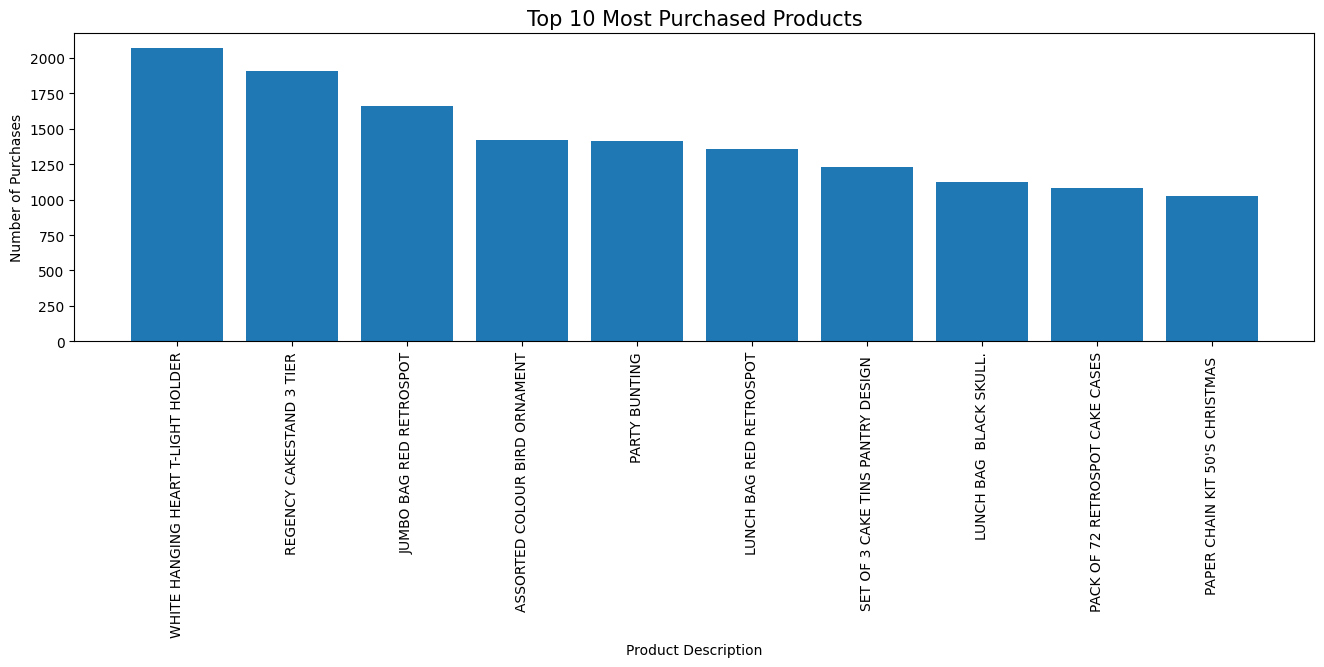

In [18]:
# Visualizing the most purchased products
top_purchase = data.groupby('Description')['TotalSales'].count().nlargest(10)

plt.figure(figsize=(16,4))
plt.bar(top_purchase.index, top_purchase.values)
plt.xticks(rotation=90)
plt.title("Top 10 Most Purchased Products", size=15)
plt.ylabel("Number of Purchases")
plt.xlabel("Product Description")
plt.xticks(rotation=90)

plt.show()

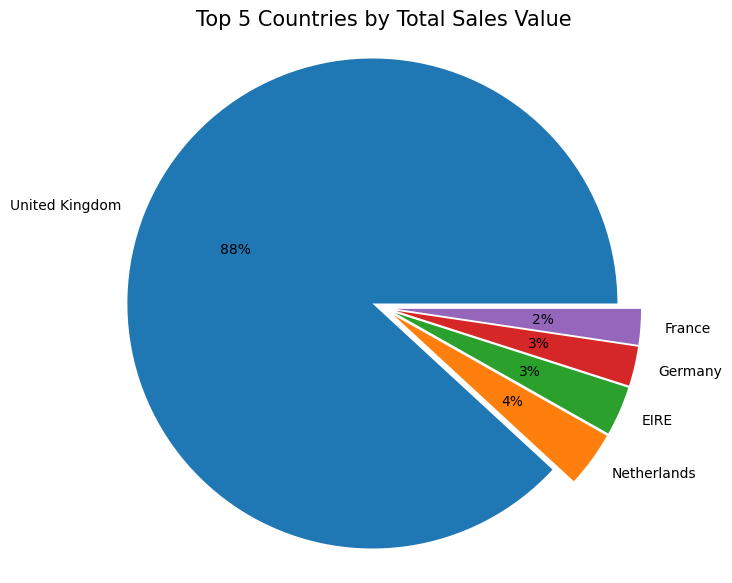

In [19]:
# Visualizing top countries by sales value
top_country = data.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)[:10]
labels = top_country[:5].index
size = top_country[:5].values

plt.figure(figsize=(7,7))
plt.pie(size, labels=labels, explode=[0.05]*5, autopct='%1.0f%%')
plt.title("Top 5 Countries by Total Sales Value", size=15)
plt.axis('equal')
plt.show()

Now we will explore on how transaction trend is changing within a day, week and across months.

To analyze this, we need to create new features from the InvoiceDate column - which denotes the date and time each transaction takes place.

In [20]:
# Extracting time components for all transactions

data['Hour'] = data['InvoiceDate'].dt.hour
data['Weekday'] = data['InvoiceDate'].dt.weekday
data['WeekdayName'] = data['InvoiceDate'].dt.day_name()
data['Month'] = data['InvoiceDate'].dt.month
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,Weekday,WeekdayName,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.299999,8,2,Wednesday,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.340000,8,2,Wednesday,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.000000,8,2,Wednesday,12


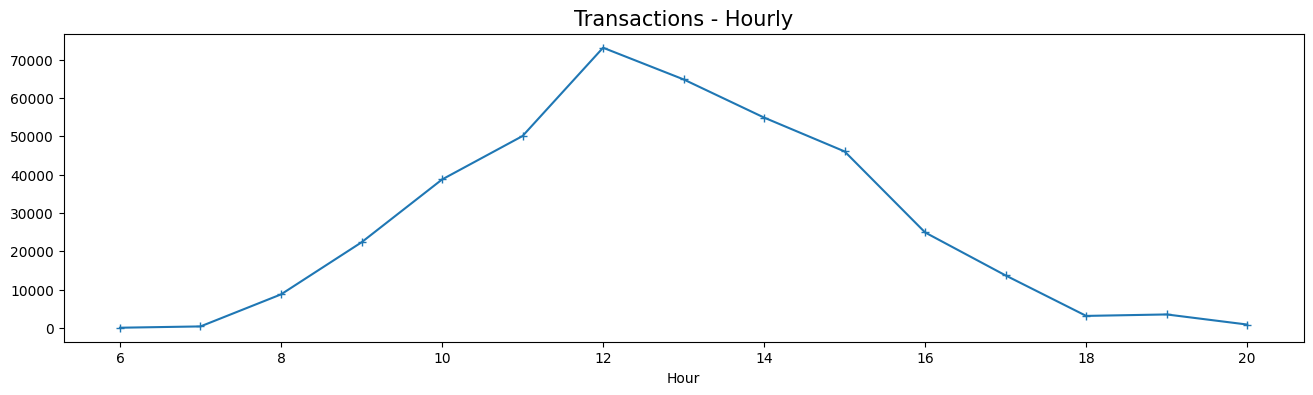

In [21]:
# Exploring hourly transaction trends

hour = data.groupby('Hour')['Quantity'].count()
plt.figure(figsize=(16,4))
hour.plot(marker='+')
plt.title("Transactions - Hourly", size=15)
plt.show()

**Observation:** The website's transaction volume peaks between 7AM and 12PM and gradually decreases until it ends at 6PM.

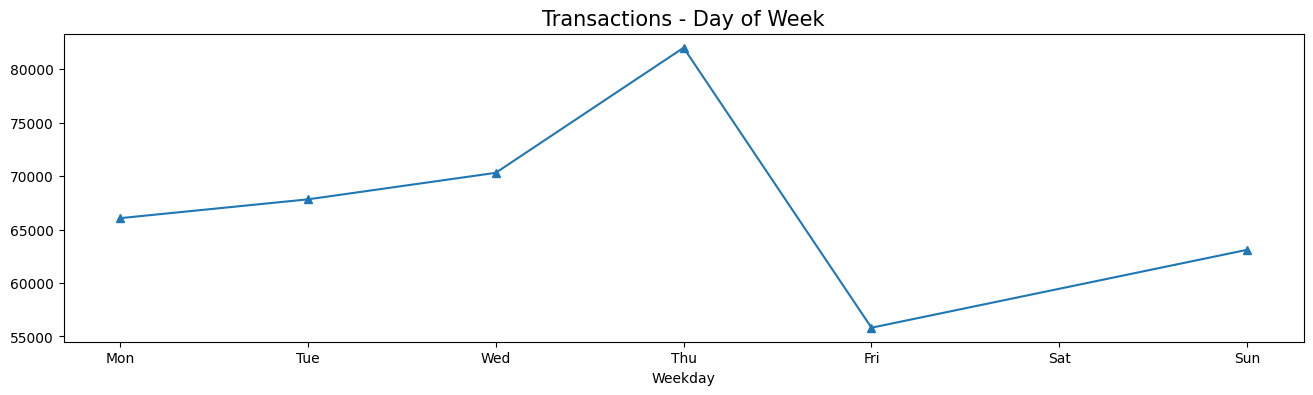

In [22]:
# Exploring weekly transaction trends

weekday = data.groupby('Weekday')['Quantity'].count()
plt.figure(figsize=(16,4))
weekday.plot(marker='^')
plt.title("Transactions - Day of Week", size=15)
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

**Observation**: During the given period, people tended to purchase more during weekdays, from Monday to Thursday. Suprisingly, the transactions dipped on weekends.

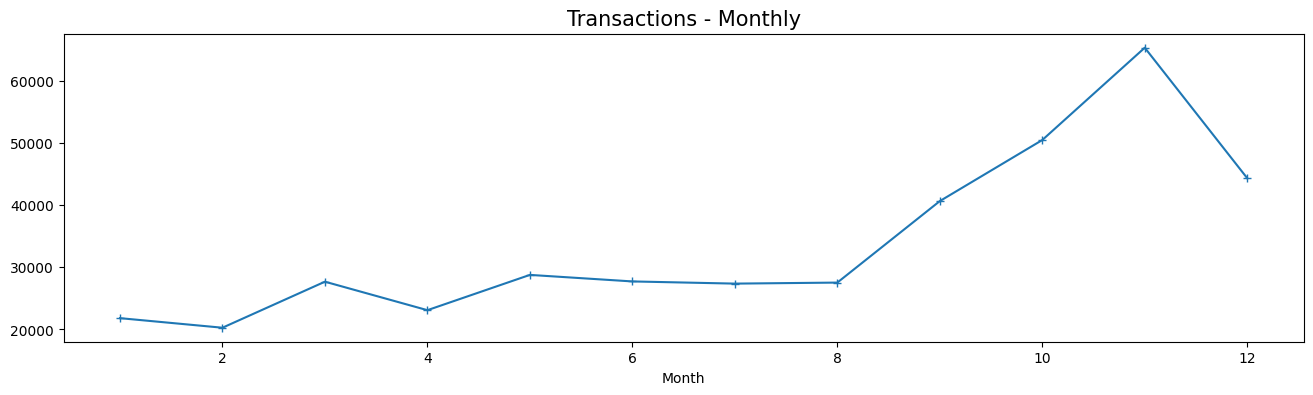

In [23]:
# Exploring monthly transaction trends

month = data.groupby('Month')['Quantity'].count()
plt.figure(figsize=(16,4))
month.plot(marker='+')
plt.title("Transactions - Monthly", size=15)
plt.show()

**Observation:** Based on the monthly trend analysis, it is evident that the transaction rate remained stable until August 2011, but then started rapidly increasing from the ember months(September onwards), which isn't suprising as preparation for christmas celebration and gift purchases are expected.

However, it is important to note that there was a sudden dip in the number of users in December, but this is due to the fact that we only have data available up until December 9th.

## **RFM Modeling**

To conduct the RFM analysis, we needed to create 3 features from the data:
* **Recency**   - [Latest date - Last invoice date] (Number of days since the last purchase date)
* **Frequency** - count of invoice numbers. (Total number of transactions made by a unique customer)
* **Monetary**  - Sum of Total sales. (Total value of transacted sales by each customer)


In [24]:
# Defining a function to generate RFM features

def RFM_Features(df, customerID, invoiceDate, transID, sales):
    ''' Create the Recency, Frequency, and Monetary features from the data '''
    # Final date in the data + 1 to create latest date
    latest_date = df[invoiceDate].max() + timedelta(1)

    # RFM feature creation
    RFMScores = df.groupby(customerID).agg({invoiceDate: lambda x: (latest_date - x.max()).days,
                                          transID: lambda x: len(x),
                                          sales: lambda x: sum(x)})

    # Converting invoiceDate to int since this contains number of days
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)

    # Renaming column names to Recency, Frequency and Monetary
    RFMScores.rename(columns={invoiceDate: 'Recency',
                         transID: 'Frequency',
                         sales: 'Monetary'}, inplace=True)

    return RFMScores.reset_index()

In [25]:
# Initiailizing the function
RFM = RFM_Features(df=data,
                  customerID="CustomerID",
                  invoiceDate="InvoiceDate",
                  transID="InvoiceNo",
                  sales="TotalSales")
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.000000
1,12347.0,2,182,4310.000016
2,12348.0,75,27,1437.240000
3,12349.0,19,72,1457.549996
4,12350.0,310,16,294.399998


In [26]:
# Exploring the RFM dataframe

RFM.describe()

,CustomerID,Recency,Frequency,Monetary
count,4363.000000,4363.000000,4363.000000,4363.000000
mean,15299.772863,92.096264,92.857208,1899.557204
std,1721.852042,100.912621,232.116234,8276.968175
min,12346.000000,1.000000,1.000000,-1192.199997
25%,13813.500000,17.000000,17.000000,294.294997
50%,15299.000000,50.000000,42.000000,645.650002
75%,16777.500000,143.000000,101.000000,1592.120003
max,18287.000000,374.000000,7971.000000,278571.619299


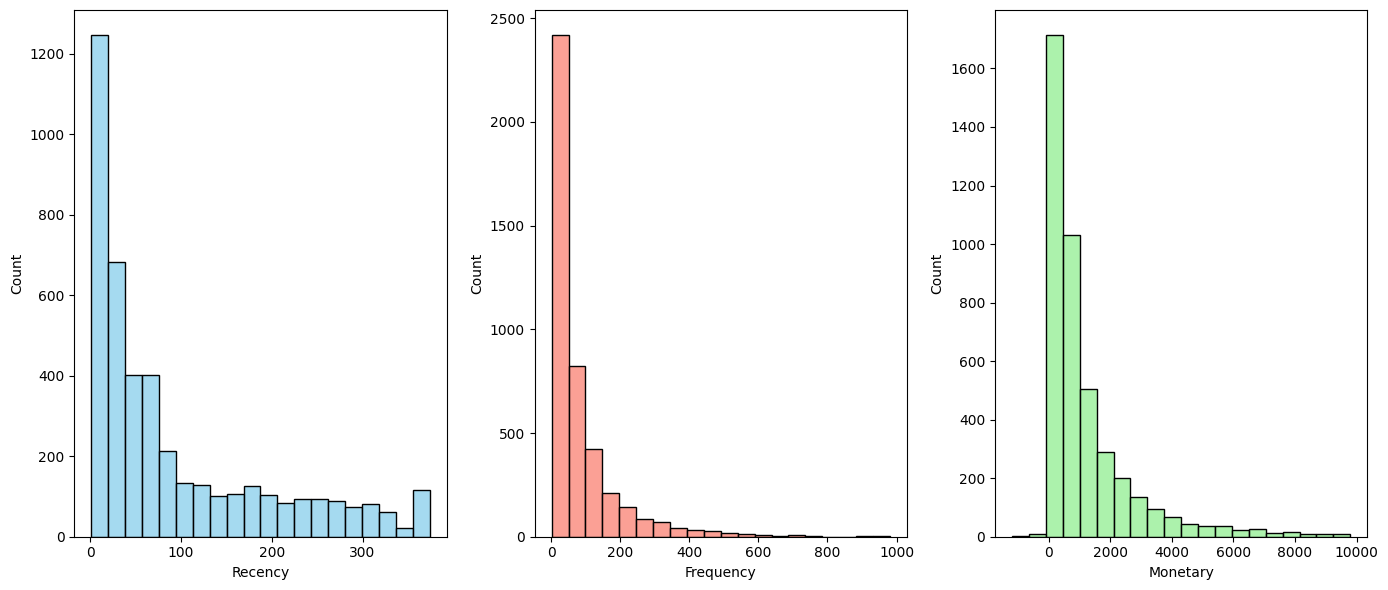

In [27]:
# Visualzing the distributions of the RFM features
fig, ax = plt.subplots(1,3, figsize=(14,6))

sns.histplot(RFM.Recency, bins=20, ax=ax[0], color='skyblue')
sns.histplot(RFM[RFM['Frequency']<1000]['Frequency'], bins=20, ax=ax[1], color='salmon')
sns.histplot(RFM[RFM['Monetary']<10000]['Monetary'], bins=20, ax=ax[2], color='lightgreen')

plt.tight_layout()
plt.show()

**Next Steps:** To conduct the RFM analysis, we proceed to rank customers based on each RFM attribute independently on a scale of 1-4, where 1 indicates a low score and 4 indicates a high score.

In [28]:
# Calculating the quartiles for the features

RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])

,Recency,Frequency,Monetary
0.25,17.0,17.0,294.294997
0.50,50.0,42.0,645.650002
0.75,143.0,101.0,1592.120003


In [29]:
# Creating quantiles for Recency, Frequency, and Monetary values

Quantiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])
quantiles_dict = Quantiles.to_dict()

print("RFM Quantiles:")
print(Quantiles)



RFM Quantiles:
      Recency  Frequency     Monetary
0.25     17.0       17.0   294.294997
0.50     50.0       42.0   645.650002
0.75    143.0      101.0  1592.120003


In [30]:
# Defining a function to rank customers based on RFM

def RFMRanking(x, variable, quantile_dict):
    ''' Ranking the Recency, Frequency, and Monetary features based on quantile values '''

    # checking if the feature to rank is Recency
    if variable == 'Recency':
        if x <= quantile_dict[variable][0.25]:
            return 4
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 3
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 2
        else:
            return 1

    # checking if the feature to rank is Frequency and Monetary
    if variable in ('Frequency','Monetary'):
        if x <= quantile_dict[variable][0.25]:
            return 1
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 2
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 3
        else:
            return 4

In [31]:
# Applying the RFM function to the dataset

RFM['R'] = RFM['Recency'].apply(lambda x: RFMRanking(x, variable='Recency', quantile_dict=Quantiles))
RFM['F'] = RFM['Frequency'].apply(lambda x: RFMRanking(x, variable='Frequency', quantile_dict=Quantiles))
RFM['M'] = RFM['Monetary'].apply(lambda x: RFMRanking(x, variable='Monetary', quantile_dict=Quantiles))

In [32]:
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346.0,326,2,0.000000,1,1,1
1,12347.0,2,182,4310.000016,4,4,4
2,12348.0,75,27,1437.240000,2,2,3
3,12349.0,19,72,1457.549996,3,3,3
4,12350.0,310,16,294.399998,1,1,2


We have calculated the ranks for each individual attribute of RFM at the customer level. We can use this to find the total number of rank groups that are created based on our ranking scale.

To do this you can simply combine all the individual R, F, and M ranks to check how many groups are created and the share of customers in each segment.

For our case, the maximum number of groups should be 4^3 = 64. Lets, check if it is true.

In [33]:
# Creating a 'Group' column in the RFM DataFrame

RFM['Group'] = RFM['R'].apply(str) + RFM['F'].apply(str) + RFM['M'].apply(str)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group
0,12346.0,326,2,0.000000,1,1,1,111
1,12347.0,2,182,4310.000016,4,4,4,444
2,12348.0,75,27,1437.240000,2,2,3,223
3,12349.0,19,72,1457.549996,3,3,3,333
4,12350.0,310,16,294.399998,1,1,2,112


In [34]:
# Aggregating the RFM Scores

RFM["Score"] = RFM[['R', 'F', 'M']].sum(axis=1)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score
0,12346.0,326,2,0.000000,1,1,1,111,3
1,12347.0,2,182,4310.000016,4,4,4,444,12
2,12348.0,75,27,1437.240000,2,2,3,223,7
3,12349.0,19,72,1457.549996,3,3,3,333,9
4,12350.0,310,16,294.399998,1,1,2,112,4


In [35]:
# Assigning each customer to distinct segments

segment = ['Bronze', 'Silver', 'Gold', 'Platinum']
RFM['Customer_Segment'] = pd.qcut(RFM['Score'], q=4, labels= segment)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Customer_Segment
0,12346.0,326,2,0.000000,1,1,1,111,3,Bronze
1,12347.0,2,182,4310.000016,4,4,4,444,12,Platinum
2,12348.0,75,27,1437.240000,2,2,3,223,7,Silver
3,12349.0,19,72,1457.549996,3,3,3,333,9,Gold
4,12350.0,310,16,294.399998,1,1,2,112,4,Bronze


In [36]:

# Grouping the data by 'Loyalty_Level' and RFM averages

customer_segment = RFM.groupby('Customer_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Score': 'mean'
})

customer_segment


,Recency,Frequency,Monetary,Score
Customer_Segment,,,,
Bronze,193.224537,14.944444,245.596528,4.094907
Silver,86.968478,33.919565,643.832989,6.488043
Gold,46.435249,83.040613,1395.621699,8.982375
Platinum,12.812352,292.391924,6598.411297,11.557007


## **Conclusion**

We have successfully segmented the customers into 4 distinct segments based on their individual behvavious and RFM scores.

**Customer Behaviour and potential targeting techniques for each Customer Segment:**


1. **Platinum:** Based on our analysis, this particular segment have made a higher number of purchases compared to others. On average, they have made a purchase 292 times within the last year, with an average time lapse of 13 days between purchases. Additionally, their average sales value is around 6.5K pounds.

> These customers are our most loyal users who have made most recent purchases, frequently used our platform, and have spent a considerable amount of money. It would be beneficial to reward them, as they can become strong brand advocates and early adopters for future products and help promote the brand.




2. **Gold:** This specific segment has made purchases an average of 83 times and their last purchase was 46 days ago. They are high spenders with an average sales value of approximately 1.3K pounds. These are our recent customers who have shown great potential for loyalty and spending. It is recommended that we offer them membership or loyalty programs, or suggest related products to encourage them to make more purchases and potentially become Platinum status members.


3. **Silver:** Users in this segment made a transaction on the platform approximately 87 days ago. They have a frequency rate of 34 times and a monetary value of 644 pounds. These customers have made a considerable number of purchases and spent a good amount of money, but they have not made any recent purchases.

> It is recommended to send them personalized campaigns, offers, and product recommendations to reconnect with them and encourage them to make new purchases.




4. **Bronze:** This group of customers are currently inactive and dormant. The average number of days since they last made a purchase was 193 days ago. However, they have transacted around 15 times on your platform, with an average sale of 245 pounds.

> These are customers who used to regularly visit and purchase on the platform but haven't been active lately. To bring them back, we can offer them relevant promotions, and also run surveys to find out what went wrong and avoid losing them to a competitor.

